In [2]:
dirID = '/Volumes/Non_Time_Machine_Files/ATL03_Files/'
    
fRT = dirID+'ATL03_20190730054214_04910404_004_01.h5'
    
bds1 = [49700777.4120872,49700777.5533872]
mdsRT = readATL03(fRT, 'gt1l', bds1) #fileID, beam, bbox

bds2 = [49700779.1088872,49700779.2501872]
mdsRT2 = readATL03(fRT, 'gt1l', bds2)

yapRT1 = calcWeights(mdsRT)
yapRT2 = calcWeights(mdsRT2)

h_RT1 = avgHeight(mdsRT)
h_RT2 = avgHeight(mdsRT2)

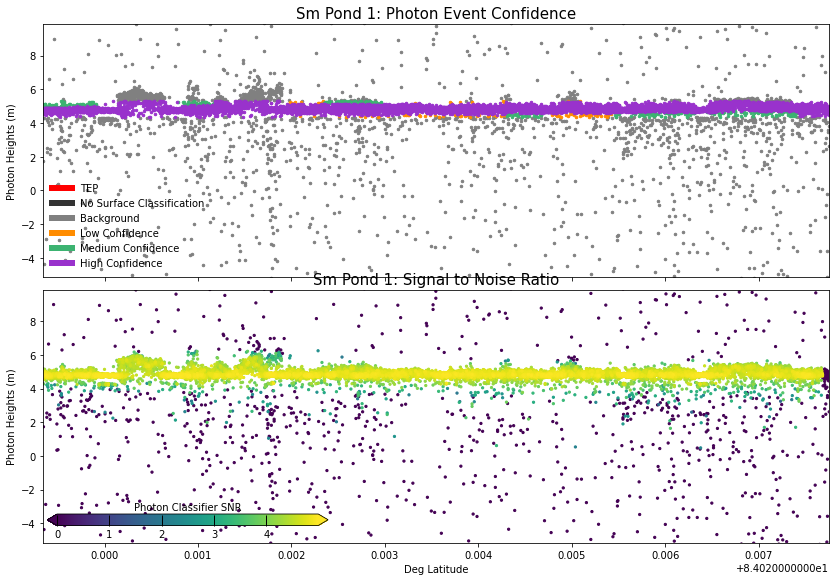

In [16]:
plotSNR(mdsRT, yapRT1, [min(mdsRT['heights']['lat_ph']), max(mdsRT['heights']['lat_ph'])], 'Sm Pond 1', h_RT1)

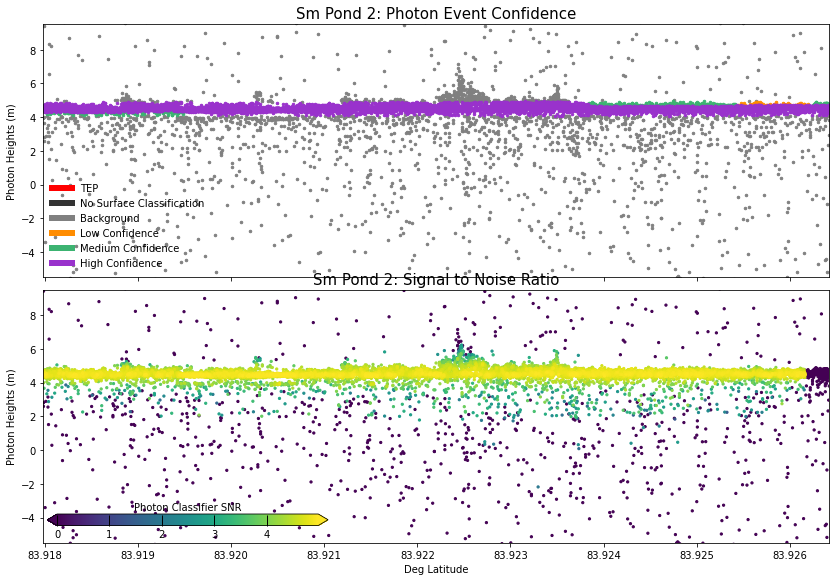

In [17]:
plotSNR(mdsRT2, yapRT2, [min(mdsRT2['heights']['lat_ph']), max(mdsRT2['heights']['lat_ph'])], 'Sm Pond 2', h_RT2)

### readATLO3(fileID, beam, bbox)

In [1]:
import h5py

#given a file, beam to focus on, and a bounding box 
def readATL03(fileID, beam, bbox):
    
    mds = {}
    
    with h5py.File(fileID, 'r') as h5:
        
        #paring down file to just heights and bckgrd_atlas:
        for top_key in ['heights', 'bckgrd_atlas']:#h5[beam].keys():
                mds[top_key] = {}
                for key in h5[beam][top_key].keys():
                    dataset = h5[beam][top_key].get(key) 
                    mds[top_key][key] = dataset[:] #copying dataset into memory
                
        ##SUBSETTING BY (LAT,LON) BOUNDING BOX:
        if len(bbox) == 4:
            lonmin, lonmax, latmin, latmax = bbox

            #boolean mask of all heights values (across keys) that satisfy bbox restrictions
            mask = (mds['heights']['lat_ph'] >= latmin) & (mds['heights']['lat_ph'] <= latmax) & \
                  (mds['heights']['lon_ph'] >= lonmin) & (mds['heights']['lon_ph'] <= lonmax) 
        
        ##SUBSETTING BY DELTA_TIME BOUNDS:
        if len(bbox) == 2:
            dt_min, dt_max = bbox
            mask = (mds['heights']['delta_time'] >= dt_min) & (mds['heights']['delta_time'] <= dt_max)
        
        for k, v in mds['heights'].items():
            mds['heights'][k] = v[mask] 
        
        dt_min, dt_max = min(mds['heights']['delta_time']), max(mds['heights']['delta_time'])
        
        #also subsetting background atlas:
        atlas_mask = (mds['bckgrd_atlas']['delta_time'] >= dt_min) & (mds['bckgrd_atlas']['delta_time'] <= dt_max) 
        for k, v in mds['bckgrd_atlas'].items():
            mds['bckgrd_atlas'][k] = v[atlas_mask]
        
        #just want signal confidence for sea ice classification:
        mds['heights']['signal_conf_ph'] = mds['heights']['signal_conf_ph'][:,2]
        
        #-- Return the datasets and variables before HDF5 file closes automatically
        return mds

In [11]:
# %%timeit -n 1 -r 3
# 8.1 s ± 82 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)

dirID = '/Volumes/Non_Time_Machine_Files/ATL03_Files/'
f07 = dirID+'ATL03_20190622202251_13070304_004_01.h5'

bbox = [-59.0, -58.0, 81.66, 82.66] #lonmin,lonmax,latmin,latmax
mds = readATL03(f07, 'gt3l', bbox) #fileID, beam, bbox


In [7]:
#write new abbreviated h5 file:

import pandas as pd
heights = pd.DataFrame.from_dict(mds['heights'])
bckgrd_atlas = pd.DataFrame.from_dict(mds['bckgrd_atlas'])

heights.to_csv('/Users/miavanderwilt/Desktop/ICESat-2/heights07.csv')
bckgrd_atlas.to_csv('/Users/miavanderwilt/Desktop/ICESat-2/bckd_atl07.csv')
                    

NameError: name 'mds' is not defined

### calcWeights(mds)

In [8]:
import icesat2_toolkit.fit
import icesat2_toolkit.time
import icesat2_toolkit.utilities

from yapc.classify_photons import classify_photons

import numpy as np

def calcWeights(mds):
    n_pe, = mds['heights']['delta_time'].shape #number of photon events

    x_atc = mds['heights']['dist_ph_along'] #along-track distance
    h_ph = mds['heights']['h_ph'][:] #photon event heights

    #photon main frames (chunked and unchunked):
    photon_mframes = mds['heights']['pce_mframe_cnt']
    pce_mframe_cnt = mds['bckgrd_atlas']['pce_mframe_cnt'] #CHUNKED

    unique_major_frames,unique_index = np.unique(pce_mframe_cnt,return_index=True)

    #telemetry band(s):
    tlm_height_band1 = mds['bckgrd_atlas']['tlm_height_band1']
    tlm_height_band2 = mds['bckgrd_atlas']['tlm_height_band2'] #likely 0

    pe_weights = np.zeros((n_pe),dtype=np.float64)

    #iterate over major frames:
    for iteration,idx in enumerate(unique_index):
        #-- sum of 2 telemetry band widths for major frame
        h_win_width = tlm_height_band1[idx] + tlm_height_band2[idx]
        #-- photon indices for major frame (buffered by 1 on each side)
        i1, = np.nonzero((photon_mframes >= unique_major_frames[iteration]-1) &
                (photon_mframes <= unique_major_frames[iteration]+1))
        #-- indices for the major frame within the buffered window
        i2, = np.nonzero(photon_mframes[i1] == unique_major_frames[iteration])
        #-- calculate photon event weights
        pe_weights[i1[i2]] = classify_photons(x_atc[i1], h_ph[i1],
                h_win_width, i2, K=5, MIN_PH=5, MIN_XSPREAD=1.0,
                MIN_HSPREAD=0.01, METHOD='brute')
        
    return pe_weights

In [23]:
pe_weights = calcWeights(mds)

### avgHeight(mds)

In [9]:
def avgHeight(mds):
    
    #find average height of high confidence photons in first 1000 photons
    hc, = np.nonzero(mds['heights']['signal_conf_ph'][0:1000] == 4)
    
    h_avg = np.average(mds['heights']['h_ph'][0:1000][hc])
    
    return h_avg

In [27]:
h_avg = avgHeight(mds) #18.774448

### subsetMDS(mds, dt_bds, h_avg)

In [10]:
def subsetMDS(mds, dt_bds, h_avg):
    
    dt_min, dt_max = dt_bds
    new_mds = copy.deepcopy(mds)
    
    mask = (new_mds['heights']['delta_time'] >= dt_min) & (new_mds['heights']['delta_time'] <= dt_max)
    
    for k, v in new_mds['heights'].items():
        new_mds['heights'][k] = v[mask]
        
    heights_df = pd.DataFrame.from_dict(new_mds['heights'], orient='index')
    heights_df = heights_df.T
            
    return heights_df

### plotDFS(df, h_avg, ax)

In [29]:
def plotDFS(df, h_avg, ax): 
    
    isTEP = df['signal_conf_ph'] == -2
    noSType = df['signal_conf_ph'] == -1
    bkgrd = ((df['signal_conf_ph'] == 0) | (df['signal_conf_ph'] == 1)) ##includes buffer
    lc = df['signal_conf_ph'] == 2
    mc = df['signal_conf_ph'] == 3
    hc = df['signal_conf_ph'] == 4
    
    #PLOT:

    ax.set_ylim(h_avg - 10, h_avg+5)#(-5,10)
#     ax.set_xlim(min(df['lat_ph']), max(df['lat_ph']))
    
    ax.plot(df['lat_ph'][isTEP], df['h_ph'][isTEP],marker='.', markersize=2.5,lw=0,color='red',label='TEP')
    ax.plot(df['lat_ph'][noSType], df['h_ph'][noSType],marker='.', markersize=2.5,lw=0,color='0.2',label='No Surface Classification')
    ax.plot(df['lat_ph'][bkgrd], df['h_ph'][bkgrd],marker='.', markersize=2.5,lw=0,color='0.5',label='Background')
    ax.plot(df['lat_ph'][lc], df['h_ph'][lc],marker='.', markersize=2.5,lw=0,color='darkorange',label='Low Confidence')
    ax.plot(df['lat_ph'][mc], df['h_ph'][mc],marker='.', markersize=2.5,lw=0,color='mediumseagreen',label='Medium Confidence')
    ax.plot(df['lat_ph'][hc], df['h_ph'][hc],marker='.', markersize=2.5,lw=0,color='darkorchid',label='High Confidence')
    
#     ax.hlines(h_avg, min(df['lat_ph']), max(df['lat_ph']))
    
    lgd = ax.legend(loc=3,frameon=False)
    lgd.get_frame().set_alpha(1.0)
    for line in lgd.get_lines():
        line.set_linewidth(6)

### dispInset(s2imageID, img_center, [y1, y2, x1, x2], ax)

In [1505]:
import os
# os.environ['GDAL_DATA'] = '/home/server/anaconda3/share/gdal'
os.environ['PROJ_LIB'] = '/opt/anaconda3/envs/test/lib/python3.9/site-packages/pyproj/proj_dir/share/proj'

import pyproj
from pyproj import Proj

import rasterio as rio
from rasterio.plot import show
from rasterio.windows import from_bounds
from rasterio.windows import Window

from skimage import exposure


# Sentinel-2 SAFE Folder that contains a TCI.jp2 true-color image file (as well as jp2's for individual bands)
s2xns = '/Users/mcvander/Desktop/ICESAT/S2B_T20XNS_20190622T213517.SAFE/GRANULE/L1C_T20XNS_A011980_20190622T194908/IMG_DATA/T20XNS_20190622T194909_TCI.jp2'

# utm20(lon,lat) will convert lat lon to utm 20 North
utm20 = Proj('epsg:32620', preserve_units=False)


def dispInset(s2imageID, img_center, line, ax):
    inset_window = 500 # 500m

    lat, lon = img_center
#     print('img_center', img_center)
#     print('line', line)
    
    inset20 = utm20(longitude= lon, latitude=lat)
#     print(inset20) #(Easting: 569834.1456577252, Northing: 9168041.431545712)

    left, right = inset20[0] - inset_window/2, inset20[0] + inset_window/2
    bottom, top = inset20[1] - inset_window/2, inset20[1] + inset_window/2

#     print('left, right', left, right)
#     print('bottom, top', bottom, top)

    with rio.open(s2imageID) as src:

        tran = src.transform
    #     print(src.gcps) #([], None) #https://github.com/mapbox/rasterio/issues/1916
    #     print(src.transform) #Affine(10.0, 0.0, 499980.0,/ 0.0, -10.0, 9200040.0)
    # #         | 10.00, 0.00, 499980.00|
    # #         | 0.00,-10.00, 9200040.00|
    # #         | 0.00, 0.00, 1.00|
    #     print(src.meta) #'width': 10980, 'height': 10980, 'count': 3
    #     show(src)
        #Window(col_off, row_off, width, height
        #inset = src.read(window=Window(inset20[0]-win/2, inset20[1]-win/2,win,win))
        inset = src.read(window=from_bounds(left, bottom, right, top, transform = tran))
        


        #fixing exposure:
    #     p2, p98 = np.percentile(inset[0], (2,98))
    #     inset_exp[0] = exposure.rescale_intensity(inset[0], in_range=(p2,p98))
    #     p2, p98 = np.percentile(inset[1], (2,98))
    #     inset_exp[1] = exposure.rescale_intensity(inset[1], in_range=(p2,p98))
    #     p2, p98 = np.percentile(inset[2], (2,98))
    #     inset_exp[2] = exposure.rescale_intensity(inset[2], in_range=(p2,p98))
    #     print(inset_exp)

        inset_reshaped = rasterio.plot.reshape_as_image(inset)
        
#         p2, p98 = np.percentile(inset_reshaped, (2,98))
#         inset_exposed = exposure.rescale_intensity(inset_reshaped, in_range=(p2,p98)) /100000
#         inset_exposed = rasterio.plot.image_adjust_bands()

        y1, y2, x1, x2 = line
        
        x1, y1 = utm20(x1, y1) 
        x2, y2 = utm20(x2, y2) 
#         print('utm x1, y1', x1, y1, x2, y2)
        
#         print('y1', y1,'bottom', bottom, 'y1 - bottom', y1 - bottom)
#         print('y2', y2,'bottom', bottom, 'y2 - bottom', y2 - bottom)

        x1 = (x1 - left)/10
        x2 = (x2 - left)/10
        y1 = (y1 - bottom)/10
        y2 = (y2 - bottom)/10
        
    #     show(inset)
        ax.imshow(inset_reshaped)
        
        #show when figure out shift:
#         ax.plot([x1,x2],[y2, y1], '-r')

<BarContainer object of 4 artists>

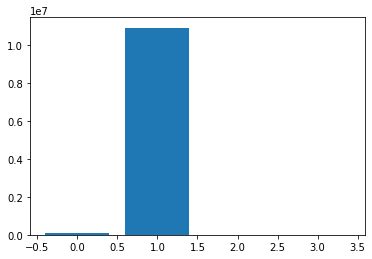

In [1530]:
# plot(np.arange(0, 3849895), mds07['heights']['dist_ph_along'])
# # len(mds07['heights']['dist_ph_along'])
# plot(range(0, len(mds07['geolocation']['segment_dist_x'])), mds07['geolocation']['segment_dist_x'])
# total_dist = max(mds07['geolocation']['segment_dist_x']) - min(mds07['geolocation']['segment_dist_x'])
total_dist
10915544.0
1241.0
66.0

plt.bar([0,1,2,3], [total_dist, 10915544.0, 1241.0, 66.0])

### findPonds(mds, pe_weights)

In [30]:
## NEAR-CONTINUOUS VERSION:
## FILTERED BY DISTANCE VERSION:

#finds continuous chunks of zero SNR 
def findPonds(mds, pe_weights, h_avg):
    
    # Find average height of segments for final plots:
    # h_avg = 20 #np.nanmean(seg_data['Segment_Elev'])#need to figure out how robust this is

    # #1. ASSIGN ALL NON-ZERO SNR values as NaN
    ph_SNR = pe_weights.astype(float) #for use of NaNs
    ph_SNR[ph_SNR > 0] = np.nan #get rid of all non-zero SNR values

    # # 2. FIND START + STOP INDICES OF ALL ZERO CHUNKS:
    m = np.concatenate(( [True], np.isnan(ph_SNR), [True] ))  # Mask
    ss = np.flatnonzero(m[1:] != m[:-1]).reshape(-1,2) #start-stop index pairs
    ss = ss - [1,1] #adjusting for indexing bds

    # 3. ONLY KEEP 0-SNR CHUNKS OF > 500 PHOTONS:
    #ss = ss[(ss[:,1] - ss[:,0]) > 150] #all 500+ photon groups (150 photons?)
        #SNR07 >> 990
    ss = ss[(ss[:,1] - ss[:,0]) > 500]        #all 500+ photon groups (150 photons?)
    #SNR >> 148
        
        
   # 4. APPEND PROXIMAL CHUNKS (< 50 photons apart)
    # *** not super elegant at the moment, but not sure how to improve (pandas shift)
    gaps = pd.DataFrame(ss, columns=['start', 'end'])
    gaps['gap'] = gaps.start - gaps.end.shift(1)
    gaps['row_number'] = range(len(gaps)) #for Pandas apply
    
    #find all starting indexes of *true* new chunks (e.g. not those < 450 photons away from other chunks
    max_gap = 50 #photons
    starts = list(gaps[(gaps.start - gaps.end.shift(1) > max_gap) | (np.isnan(gaps.start - gaps.end.shift(1)))].index)
    
    def find_nearest_below(v):
        for i in range(len(starts)):
            if starts[i] > v:
                return starts[i-1]
            elif starts[i] == v:
                return starts[i]
        return starts[-1]
        
    gaps['start_row'] = gaps['row_number'].apply(find_nearest_below)
    # print(gaps) #147
    
    chunks = gaps.groupby('start_row').agg({'start':min,'end':max})
    # print(chunks) #142
    
        
    ## 4. Convert start-stop indices to dist_ph_along bounds and delta_time bounds
    bds = np.column_stack((mds['heights']['delta_time'][chunks.start], mds['heights']['delta_time'][chunks.end]))
    #print(bds)
    bds_x = np.column_stack((mds['heights']['dist_ph_along'][chunks.start], mds['heights']['dist_ph_along'][chunks.end]))
    #print(bds_x)
    dx = abs(bds_x[:,1]-bds_x[:,0])
    
    print('tot_SNR_dist', sum(dx))
    #print(dx)
    

    ## 5. Filtering out near-continuous chunks by distance along > 50m
    #start=126?, 25m >> 66, 50m >> 36, 
    bds = bds[dx > 50]
    #bds = bds[dx > 100]
    #print(len(bds))
    #bds = bds[dx > 150]
    #print(len(bds))

    ## *** won't be needed eventually:
    #filtering out land candidates that snuck in:
    bds = bds[0:15]
    
    ponds = []
    SNR_dist = 0


    # 5. PLOTTING pond candidates:
    for i in np.arange(len(bds)):

        bounds = [bds[i][0]-.001, bds[i][1]+.001]

        #SUBSET MDS 
        dfx = subsetMDS(mds, bounds)
        SNR_dist = SNR_dist + (max(dfx['dist_ph_along']) - min(dfx['dist_ph_along']))
        
        # *** take out
        sig_conf = dfx['signal_conf_ph'].str[2]
        dfx['signal_conf_ph'] = sig_conf.values[:]
        


        #FILTER FOR PHOTON DENSITY (more density below high confidence photon 'surface' than below)
                #extrapolate high conf 'surface':
        #     find band around surface by taking average height of high(est) confidence photons at the start/end
        
        
        book_ends = pd.concat([dfx.head(150), dfx.tail(150)])
                
        hc = (book_ends['signal_conf_ph'] == 4)
        if any(hc):
            h_avg = np.average(book_ends['h_ph'][hc])
        else:
            mc = (book_ends['signal_conf_ph'] == 3)
            if any(mc_T):
                h_avg = np.average(book_ends['h_ph'][mc])
            else:
                print('not enough high conf photons to reliably determine average surface elevation')
                h_avg = np.average(book_ends['h_ph'])
        
        #        subset data frame to 20 m above, 20m below
        # ** think this should probably make its way into an earlier step
        dfx = dfx[(dfx['h_ph'] < 20+h_avg) & (dfx['h_ph'] > h_avg-20)]
        
        density_dist = 0
        
        #if at least 50% more photons below surface than above:
        if (1.5 * len(dfx[dfx['h_ph'] > h_avg]) < len(dfx[dfx['h_ph'] < h_avg])):
            #print(bounds[0], ", ", bounds[1])
            
            fig, ax = plt.subplots(1,3, figsize = (28,4), gridspec_kw={'width_ratios': [3, 1, 3]})
            #fig, ax = plt.subplots(1,1,figsize=(12,4))
            #plt.xlabel('Latitude',fontsize=20)
            #plt.ylabel('Photon Heights (m)',fontsize=20)
        
            plotDFS(dfx, h_avg, ax[0])
            
            density_dist = density_dist + (max(dfx['dist_ph_along']) - min(dfx['dist_ph_along']))
            

            #DISPLAY INSET FOR ALL CANDIDATES
            dispInset(s2xns, [np.average(dfx['lat_ph']), np.average(dfx['lon_ph'])], 
                      [min(dfx['lat_ph']), max(dfx['lat_ph']),min(dfx['lon_ph']), max(dfx['lon_ph'])], ax[1])
            
            cv_bottom = curveFit(dfx, h_avg)
            
            plotFit(dfx, cv_bottom, h_avg, ax[2])
            
            ponds.append(dfx)
            
            print(SNR_dist)
            print(density_dist)
            
    return ponds

In [31]:
pds = findPonds(mds, pe_weights, h_avg)

tot_SNR_dist 0


### plotSNR(mds, SNR, dt_bds, pondID, h_avg)

In [15]:
import matplotlib.pyplot as plt

#https://github.com/tsutterley/read-ICESat-2/blob/main/notebooks/Read%20ICESat-2%20ATL03.ipynb
def plotSNR(mds, SNR, bounds, pondID, h_avg):
    
    ht = mds['heights']['h_ph'][:]
    lat = mds['heights']['lat_ph'][:]
    lat_min, lat_max = bounds

    #CLASSIFICATION CONFIDENCE:
    #-- Signal classification confidence for sea ice
    #-- 0=Land; 1=Ocean; 2=SeaIce; 3=LandIce; 4=InlandWater
    ice_sig_conf = mds['heights']['signal_conf_ph'][:] 
    #confidence level associated with each photon event: 
    isTEP, = np.nonzero(ice_sig_conf == -2)  # -2: TEP (Transmit Echo Pulse) returns
    noSType, = np.nonzero(ice_sig_conf == -1) #-- -1: Events not associated with a specific surface type
    bkgrd, = np.nonzero((ice_sig_conf == 0) | (ice_sig_conf == 1)) ##0: noise, 1: buffer (aka bckgrd)
    #-- find photon events of progressively higher confidence
    lc, = np.nonzero(ice_sig_conf == 2) #low
    mc, = np.nonzero(ice_sig_conf == 3) #medium
    hc, = np.nonzero(ice_sig_conf == 4) #high
    
    #PLOTS:
    fig,ax = plt.subplots(num=2,nrows=2,sharex=True,figsize=(12,8))
    size = 5 #dot size
    
    #CONFIDENCES:   
    ax[0].plot(lat[isTEP], mds['heights']['h_ph'][isTEP],marker='.', markersize=size,lw=0,color='red',label='TEP')
    ax[0].plot(lat[noSType], mds['heights']['h_ph'][noSType],marker='.', markersize=size,lw=0,color='0.2',label='No Surface Classification')
    ax[0].plot(lat[bkgrd], mds['heights']['h_ph'][bkgrd],marker='.', markersize=size,lw=0,color='0.5',label='Background')
    ax[0].plot(lat[lc], mds['heights']['h_ph'][lc],marker='.', markersize=size,lw=0,color='darkorange',label='Low Confidence')
    ax[0].plot(lat[mc], mds['heights']['h_ph'][mc],marker='.', markersize=size,lw=0,color='mediumseagreen',label='Medium Confidence')
    ax[0].plot(lat[hc], mds['heights']['h_ph'][hc],marker='.', markersize=size,lw=0,color='darkorchid',label='High Confidence')
    
    
    #SIGNAL TO NOISE RATIO:
    isort = np.argsort(SNR)
    sc = ax[1].scatter(lat[isort],mds['heights']['h_ph'][isort],
                        c=SNR[isort],s=size)

    #-- add colorbar for scatter plot
    cax = fig.add_axes([0.075, 0.080, 0.325, 0.02])
    cbar = fig.colorbar(sc, cax=cax, extend='both', extendfrac=0.0375,
    drawedges=False, orientation='horizontal')
    cbar.solids.set_rasterized(True)     # -- rasterized colorbar to remove lines
    cbar.ax.set_xlabel('Photon Classifier SNR')
    cbar.ax.xaxis.set_label_position('top')
    cbar.ax.tick_params(which='both',width=1,length=11,direction="in")
    
    #LEGEND
    lgd = ax[0].legend(loc=3,frameon=False)
    lgd.get_frame().set_alpha(1.0)
    for line in lgd.get_lines():
        line.set_linewidth(6)
    
    #AXES:
    ax[1].set_xlabel('Deg Latitude',fontsize=10)
    ax[0].set_ylabel('Photon Heights (m)',fontsize=10)
    ax[1].set_ylabel('Photon Heights (m)',fontsize=10)
    ax[0].set_title((pondID+': Photon Event Confidence'), fontsize=15)
    ax[1].set_title((pondID+': Signal to Noise Ratio'), fontsize=15)
                    
    ax[1].set_xlim(lat_min, lat_max)
    ax[0].set_ylim(h_avg - 10,h_avg+5)
    ax[1].set_ylim(h_avg - 10,h_avg+5)
    
    #-- adjust the figure axes
    fig.subplots_adjust(left=0.07, right=0.98, bottom=0.05, top=0.95, hspace=0.05)
    
    plt.show()

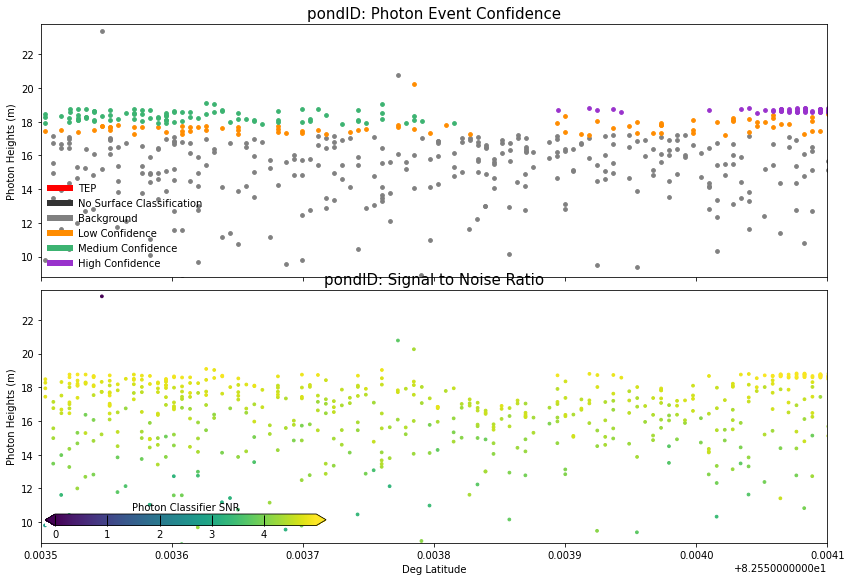

In [46]:
plotSNR(mds, pe_weights, [82.5535, 82.5541], 'pondID', h_avg)

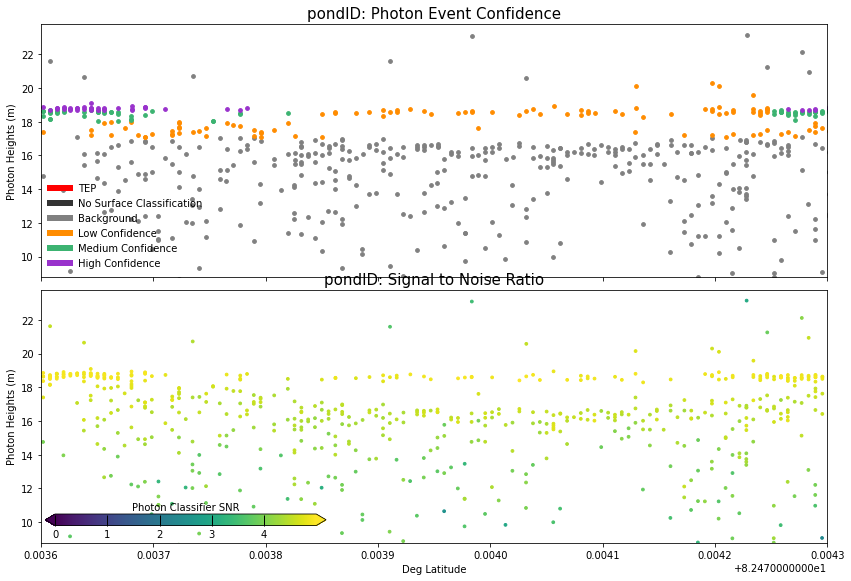

In [47]:
plotSNR(mds, pe_weights, [82.4736, 82.4743], 'pondID', h_avg)

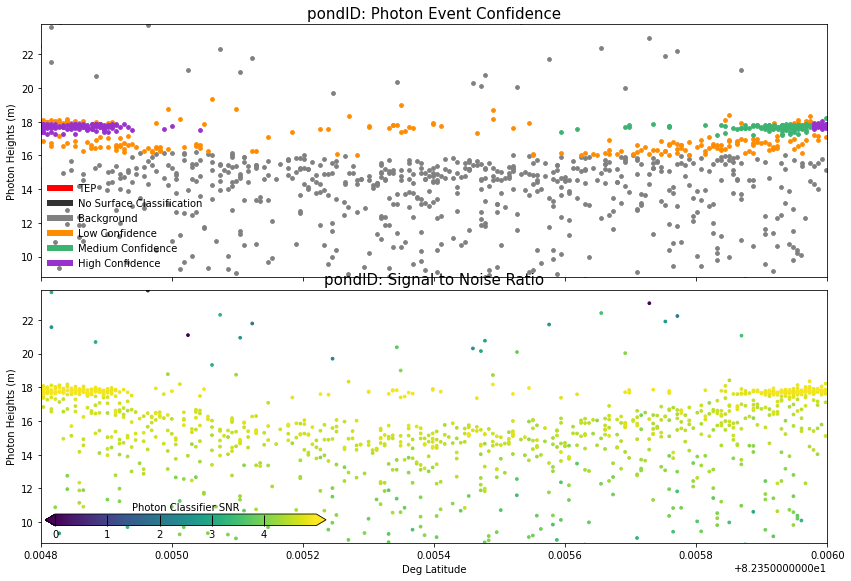

In [48]:
plotSNR(mds, pe_weights, [82.3548, 82.3560], 'pondID', h_avg)

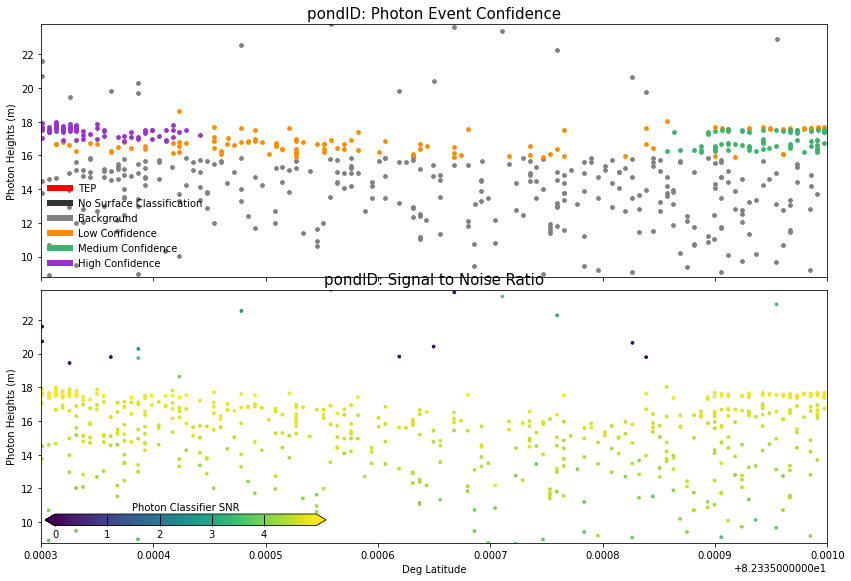

In [49]:
plotSNR(mds, pe_weights, [82.3353, 82.336], 'pondID', h_avg)

### curveFit(df, h_avg)

In [1471]:
from scipy.signal import argrelextrema
from unidip import UniDip
import bisect
from scipy.optimize import curve_fit

def curveFit(df_in, h_avg):

    #just extrapolating surface, removing it from curve finding (10 cm below extrapolated surface)
    hacked = copy.deepcopy(df_in)
    
    #setting first dist_ph_along value to 0
    hacked['dist_ph_along'] =  hacked['dist_ph_along'] - min(hacked['dist_ph_along'])

    #removing surface
    hacked = hacked[(hacked['h_ph'] < (h_avg - 0.25))]

    heights = []
    dist_along = []
    
    dist_along.append(0)
    heights.append(h_avg) #initially at surface
    

    def chunker(seq, size):
        return (seq[pos:pos + size] for pos in np.arange(0, len(seq), size))


    #take a 10m window chunks:
    dx = 10
    
    for x0 in np.arange(0, max(hacked['dist_ph_along']), dx):
        
        chunk = hacked[(hacked['dist_ph_along'] > x0) & (hacked['dist_ph_along'] < (x0+dx))]        
        
        
        #if empty stretch of distance:
        if len(chunk)< 25:
            continue
            
        #bottom as 90th percentile of non-surface photons
        else:
            heights.append(np.percentile(chunk['h_ph'], 90))
            dist_along.append(np.average(chunk['dist_ph_along']))
    
#         #if sparse photon density, use mean or mode:
#         elif len(chunk) < 25:
#             heights.append(np.average(chunk['h_ph']))
#             dist_along.append(x0+dx/2)
# #             continue

#         #otherwise, fit exp mod gaus to height returns:    
#         else:
#             cts,bins = np.histogram(chunk['h_ph'],bins='auto') 
#             expected = [.1,16, 1, 6]# K, mu, sigma, A

#             bins=(bins[1:]+bins[:-1])/2 #needed for curve fitting
#             params, cov = curve_fit(expmodgaus, bins, cts, expected)
# #             plt.plot(bins, expmodgaus(bins,*params), color='orange', lw=3)
            
#             heights.append(params[1])
#             dist_along.append(x0+dx/2)

#             plt.show()
            

#         dist_along.append(np.average(chunk['dist_ph_along']))

    heights.append(h_avg)
    dist_along.append(max(hacked['dist_ph_along']))

    curve = pd.DataFrame(zip(dist_along, heights), columns=['dist_along','heights'])
            
    return curve

In [1378]:
# from scipy.signal import argrelextrema
# from unidip import UniDip
# import bisect
# from scipy.optimize import curve_fit

# def curveFit(df, h_avg):


#     #just extrapolating surface, removing it from curve finding (10 cm below extrapolated surface)
#     hacked = copy.deepcopy(df)
    
#     #setting first dist_ph_along value to 0
#     hacked['dist_ph_along'] =  hacked['dist_ph_along'] - min(hacked['dist_ph_along'])

#     #removing surface
#     hacked = hacked[(hacked['h_ph'] < (h_avg - 0.1))]

#     heights = []
#     dist_along = []
    

#     def chunker(seq, size):
#         return (seq[pos:pos + size] for pos in np.arange(0, len(seq), size))

#     #     #take chunks of 150 photons:
#     for chunk in chunker(hacked,150):


#         #take bottom surface as mean of exponentially modified gaussian
#         cts,bins = np.histogram(chunk['h_ph'],bins='auto') #'auto' bins? or 25
#         expected = [.1,16, 1, 6]# K, mu, sigma, A

#         bins=(bins[1:]+bins[:-1])/2 #needed for curve fitting

#         params, cov = curve_fit(expmodgaus, bins, cts, expected)
# #             plt.plot(bins, expmodgaus(bins,*params), color='orange', lw=3)

#         heights.append(params[1]) #mu of EMG
        
# #         print('avg. dist along', np.average(chunk['dist_ph_along']),'avg. dist - x0', np.average(chunk['dist_ph_along']) - x0)
#         dist_along.append(np.average(chunk['dist_ph_along']))


#     curve = pd.DataFrame(zip(dist_along, heights), columns=['dist_along','heights'])
            
#     return curve

### atl07(fileID, beam)

In [1490]:
# fID = '/Users/mcvander/Desktop/ICESAT/icesat-2-main/ATL07-01_20190622200154_13070301_004_01.h5'

# matl07,att07,beamat07 = read_HDF5_ATL07(fID)
# c1 = matl07['gt3l']['sea_ice_segments']['latitude']
# c2 = matl07['gt3l']['sea_ice_segments']['seg_dist_x']
# c3 = matl07['gt3l']['sea_ice_segments']['heights']['height_segment_height']
# c4 = matl07['gt3l']['sea_ice_segments']['heights']['height_segment_type']
# c5 = matl07['gt3l']['sea_ice_segments']['delta_time]
c6 = matl07['gt3l']['sea_ice_segments']['heights']['height_segment_height'] - matl07['gt3l']['sea_ice_segments']['geophysical']['height_segment_mss']

atl007 = pd.DataFrame(zip(c1,c2,c3,c4,c5, c6), columns=['latitude','x','h','type','delta_time', 'h_adj'])
# atl007 = atl007[(atl007['delta_time'] >= 46470442.368252) & (atl007['delta_time'] <= 46470442.386552)]
# xp = atl007['x'] - atl007['x'].iloc[0]
# np.average(atl007['h'])
#'geolocation', 'geophysical', 'heights', 'stats', 'delta_time', 'geoseg_beg', 'geoseg_end', 'height_segment_id', 'latitude', 'longitude', 'seg_dist_x'

In [1579]:
# max(atl007.delta_time)
max(mds07['heights']['delta_time'])

46470451.08775238

In [1566]:
fID = '/Users/mcvander/Desktop/ATL10-01_20190622200154_13070301_004_01.h5'

lonmin, lonmax = -63.784459381944, -50.07441723
latmin, latmax = 81.8205485463, 82.794165326

bbox = lonmin,lonmax,latmin,latmax

atl10 = readATL10(fID, 'gt3l', bbox)


In [1582]:
# c1 = atl10['freeboard_beam_segment']['delta_time']
# c2 = atl10['freeboard_beam_segment']['beam_fb_height']
# c3 = atl10['freeboard_beam_segment']['latitude']
# c4 = atl10['freeboard_beam_segment']['longitude']

# atl10df = pd.DataFrame(zip(c1,c2,c3,c4), columns=['dt','fb_h','lat','lon'])
# atl10df = atl10df[(atl10df['dt'] >= 46470435.200352035) & (atl10df['dt'] <= 46470451.08775238)]
atl10df = atl10df[(atl10df['lat'] >= 81.8205485463) & (atl10df['lat'] <= 82.794165326)]



# min(atl10['freeboard_beam_segment']['delta_time']), max(atl10['freeboard_beam_segment']['delta_time'])

# latmin, latmax = 81.8205485463, 82.794165326

atl10df

,dt,fb_h,lat,lon
199,4.647044e+07,3.325185e-01,82.758134,-57.449361
200,4.647044e+07,2.798693e-01,82.675150,-57.646748
201,4.647044e+07,4.189524e-01,82.588675,-57.841543
202,4.647044e+07,3.986866e-01,82.501602,-58.028971
203,4.647044e+07,3.402823e+38,82.416634,-58.213544
204,4.647044e+07,3.402823e+38,82.329683,-58.394751
205,4.647044e+07,3.402823e+38,82.244607,-58.577662
206,4.647045e+07,3.402823e+38,82.193153,-58.830444


In [1583]:
import dill                            
filepath = 'session.pkl'
dill.dump_session(filepath) # Save the session
dill.load_session(filepath) # Load the session


TypeError: cannot pickle 'dict_keys' object

In [1553]:
def readATL10(fileID, beam, bbox):
    
    mds = {}
    
    with h5py.File(fileID, 'r') as fi:

        for top_key in fi[beam].keys():
            mds[top_key] = {}

            #ph_lat, ph_lon, etc.
            for key in fi[beam][top_key].keys():
                if isinstance(fi[beam][top_key].get(key), h5py.Group):
                    mds[top_key][key] = {}
                    for sub_key in fi[beam][top_key][key].keys():
                        dataset = fi[beam][top_key][key].get(sub_key)
                        mds[top_key][key][sub_key] = dataset[:]
                else:
                    dataset = fi[beam][top_key].get(key) #(val) dataset will get closed w file
                    mds[top_key][key] = dataset[:] #so copying dataset into memory
                    
        return mds

### plotFit(df, curve, h_avg, ax):

In [1498]:
def plotFit(df, curve, h_avg, ax):
#     ax.xlabel('Distance Along-Track (m)',fontsize=20)
#     ax.ylabel('Photon Heights (m)',fontsize=20)
    ax.set_ylim(h_avg - 10, h_avg+5)#(-5,10)
    ax.set_xlim(-5, max(curve['dist_along'])+5)
    

    ax.scatter(df['dist_ph_along'] - df['dist_ph_along'].iloc[0], df['h_ph'], s=2.5, c=df['signal_conf_ph'],cmap='binary') #photon heights
#     plot(np.arange(5, len(curve)*10+5,10), curve)
    ax.plot(curve['dist_along'], curve['heights'], '-c', lw=2) #aggregated height guesses
    ax.hlines(h_avg,0, max(curve['dist_along']), 'c', lw=2) #surface guess

#     #ATL07
    ax2 = ax.twinx()
    atl007sub = atl007[(atl007['delta_time'] >= min(df['delta_time'])) & (atl007['delta_time'] <= max(df['delta_time']))]
    xp = atl007sub['x'] - atl007sub['x'].iloc[0]
    ax2.plot(xp, atl007sub['h_adj'],c='r',alpha=.75)
    ax2.set_ylim(np.average(atl007sub['h_adj'])-10, np.average(atl007sub['h_adj'])+5)#(-5,10)

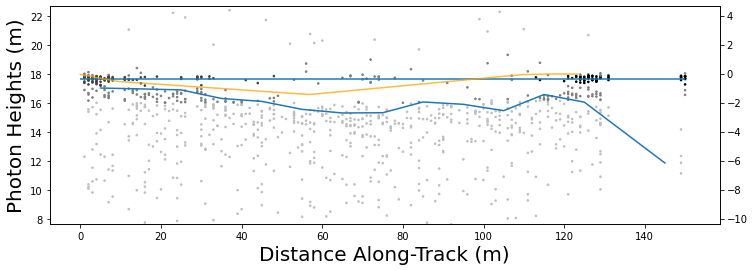

In [852]:
plotFit(pond_dfs07[7], curve7, avg7)

In [19]:
!conda list

# packages in environment at /Applications/anaconda3/envs/iceclone:
#
# Name                    Version                   Build  Channel
affine                    2.3.0                    pypi_0    pypi
anyio                     3.3.4                    pypi_0    pypi
appnope                   0.1.2           py37hecd8cb5_1001  
argon2-cffi               20.1.0           py37h9ed2024_1  
async_generator           1.10             py37h28b3542_0  
attrs                     21.2.0             pyhd3eb1b0_0  
babel                     2.9.1                    pypi_0    pypi
backcall                  0.2.0              pyhd3eb1b0_0  
blas                      1.0                         mkl  
bleach                    3.3.0              pyhd3eb1b0_0  
branca                    0.4.2                    pypi_0    pypi
bzip2                     1.0.8                h1de35cc_0  
ca-certificates           2021.5.25            hecd8cb5_1  
cairo                     1.14.12              hc4e6be7_4